# Foreign Exchange Forecasting

## Import Library

In [52]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime, pytz

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

## Constants

In [53]:
# Load data from Google Spreadsheet
SHEET_ID = '1JDNv_mArl-GPIpxuWS5GxgVEwvjXocS1MrXGc6TYs8M'
SHEET_NAME = 'USD/IDR'

## Pre-Processing

In [54]:
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
data = pd.read_csv(url)

# Drop unused columns
data = data.drop('Unnamed: 2', axis=1)

# Convert Date columns to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y %H:%M:%S')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1220 non-null   datetime64[ns]
 1   Close   1220 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [55]:
data.head()

,Date,Close
0,2020-01-01 23:58:00,13689.23
1,2020-01-02 23:58:00,13884.79
2,2020-01-03 23:58:00,13935.46
3,2020-01-04 23:58:00,13935.46
4,2020-01-05 23:58:00,13934.32


In [56]:
data = data.groupby([pd.Grouper(key='Date', freq='D')]).first().reset_index()
data = data.set_index('Date')

In [57]:
split_date = '1-Jan-2023'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

In [58]:
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

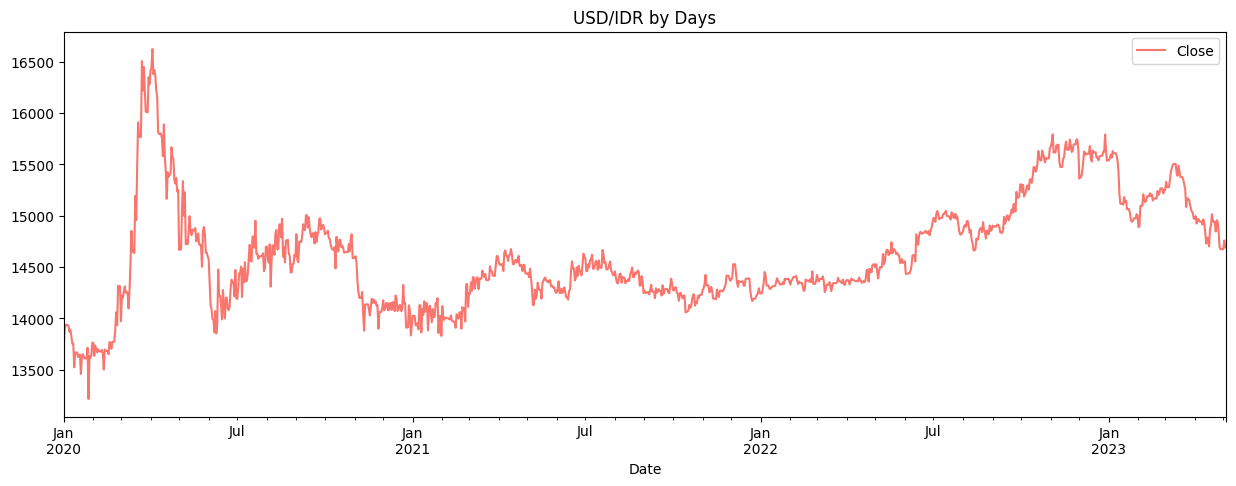

In [59]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data.plot(style='', figsize=(15,5), color=color_pal[0], title='USD/IDR by Days')

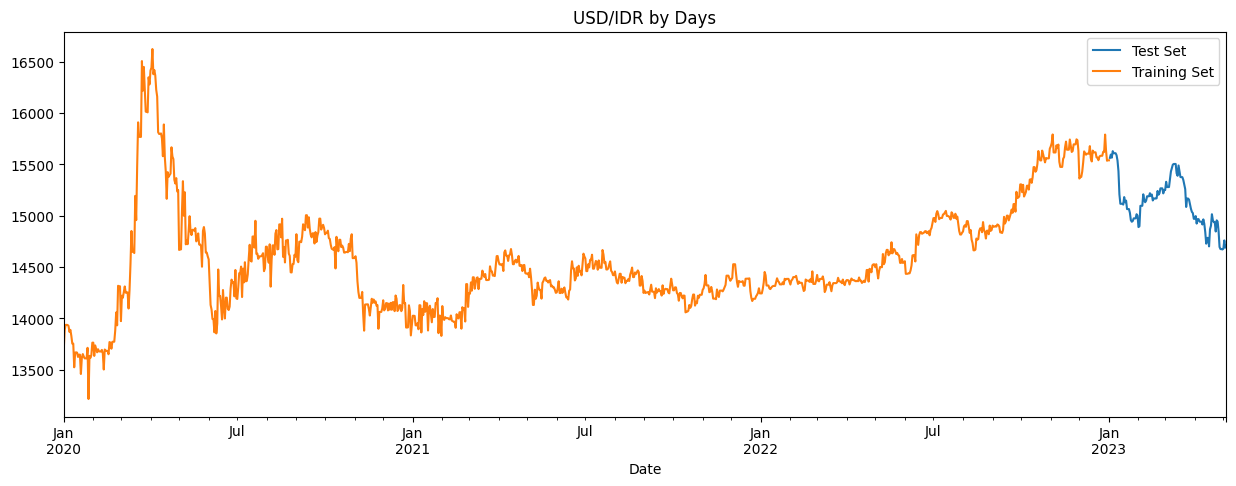

In [60]:
_ = data_test \
    .rename(columns={'Close': 'Test Set'}) \
    .join(data_train.rename(columns={'Close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='USD/IDR by Days', style='')

## Model Build

In [61]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(1,1)),
    Dense(1)
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=['mse'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                10400     
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_train,
                    y_train,
                    epochs=100)

Epoch 1/100
35/35 [==============================] - 1s 1ms/step - loss: 0.0749 - mse: 0.1497
Epoch 2/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0440 - mse: 0.0880
Epoch 3/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0214 - mse: 0.0428
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0088 - mse: 0.0175
Epoch 5/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0053 - mse: 0.0105
Epoch 6/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0095
Epoch 7/100
35/35 [==============================] - 0s 2ms/step - loss: 0.0045 - mse: 0.0090
Epoch 8/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0042 - mse: 0.0084
Epoch 9/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0039 - mse: 0.0078
Epoch 10/100
35/35 [==============================] - 0s 1ms/step - loss: 0.0036 - mse: 0.0072
Epoch 11/100
35/35 [==============================] - 0s 1m

## Predictions

In [63]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_USD_price = model.predict(inputs)
predicted_USD_price = sc.inverse_transform(predicted_USD_price)

4/4 [==============================] - 0s 1ms/step


In [64]:
data_test['Close_Price_Prediction'] = predicted_USD_price
data_all = pd.concat([data_test, data_train], sort=False)

In [65]:
#saving the predicted values in a common data frame for future comparision
final_data = data_all
final_data = final_data.reset_index()
final_data = final_data.rename(columns={'Close_Price_Prediction': 'lstm'})
final_data = final_data[['Date','Close','lstm']]

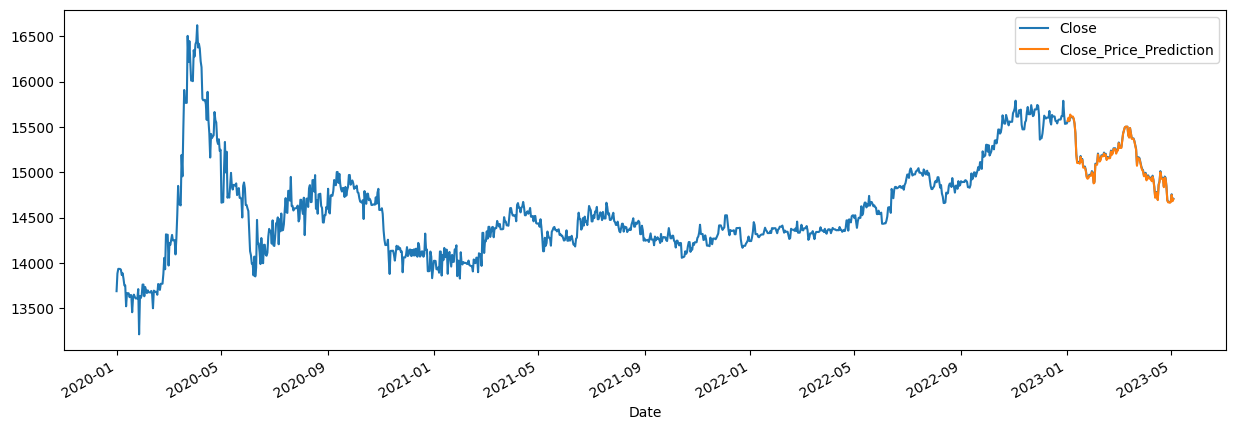

In [66]:
_ = data_all[['Close','Close_Price_Prediction']].plot(figsize=(15, 5))

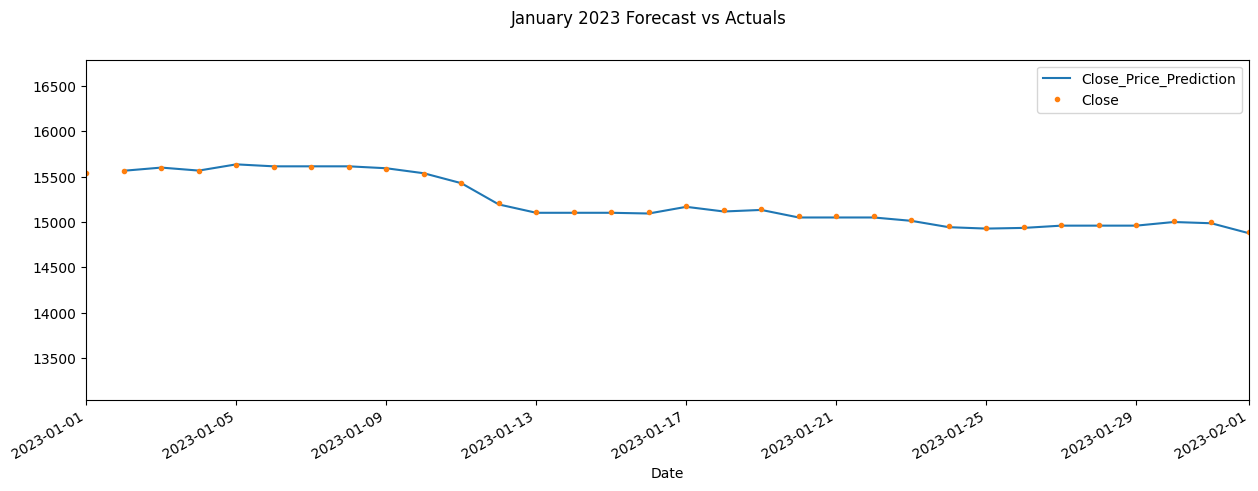

In [67]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Close_Price_Prediction','Close']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2023', upper='02-01-2023')
plot = plt.suptitle('January 2023 Forecast vs Actuals')

In [68]:
#calculate MSE and MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Price_Prediction'])

91.6495414767998

In [69]:
mean_absolute_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Price_Prediction'])

9.075373158028443

In [70]:
np.sqrt(mean_squared_error(y_true=data_test['Close'],
                           y_pred=data_test['Close_Price_Prediction']))

9.573376701916613